<a href="https://colab.research.google.com/github/beaten-by-the-market/dart_disclosure/blob/main/buyback_mkt20005.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 자기주식 '신탁' '처분'은 정말 그렇게 적었을까?

## 파이썬 세팅

* 필요한 패키지 Import

In [1]:
import pandas as pd
import requests
from io import BytesIO, StringIO
from time import sleep
from tqdm import tqdm
from bs4 import BeautifulSoup
import json
import re
import numpy as np

* 시각화를 위한 세팅(코랩)
코랩 환경에서 시각화에 한글이 깨지지 않도록 조치

In [2]:
# 필요한 라이브러리 설치
!pip install adjustText

import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from adjustText import adjust_text

# 한글 폰트 설정 (Google Colab 환경에서)
!apt-get update -qq
!apt-get install fonts-nanum* -qq

fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=10)

W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
Selecting previously unselected package fonts-nanum.
(Reading database ... 126209 files and directories currently installed.)
Preparing to unpack .../fonts-nanum_20200506-1_all.deb ...
Unpacking fonts-nanum (20200506-1) ...
Selecting previously unselected package fonts-nanum-coding.
Preparing to unpack .../fonts-nanum-coding_2.5-3_all.deb ...
Unpacking fonts-nanum-coding (2.5-3) ...
Selecting previously unselected package fonts-nanum-eco.
Preparing to unpack .../fonts-nanum-eco_1.000-7_all.deb ...
Unpacking fonts-nanum-eco (1.000-7) ...
Selecting previously unselected package fonts-nanum-extra.
Preparing to unpack .../fonts-nanum-extra_20200506-1_all.deb ...
Unpacking fonts-nanum-extra (20200506-1) ...
Setting up fonts-nanum-extra (20200506-1) ...
Setting up fonts-nanum (20200506-1) ...
Setting up fo

## 20005 화면으로 전종목 확인해보기

In [ ]:
#거래소 홈페이지에서 불러오기
# 조회연도 입력하기(2015~2024)
st_y = '2015'
end_y = '2024'
#화면번호 20005(자사주취득/처분내역(개별종목))

gen_otp_url = 'http://data.krx.co.kr/comm/fileDn/GenerateOTP/generate.cmd'
gen_otp_data = {
    'locale': 'ko_KR',
    'tboxisuCd_finder_stkisu0_2': '전체',
    'isuCd': 'ALL',
    'isuCd2': 'ALL',
    'codeNmisuCd_finder_stkisu0_2': '',
    'param1isuCd_finder_stkisu0_2': 'ALL',
    'trstkTpCd': 'ALL',
    'trstkAcqstdispTpCd': 'ALL',
    'strtDd': f'{st_y}0101',
    'endDd': f'{end_y}1224',
    'mktId': 'ALL',
    'share': '1',
    'csvxls_isNo': 'true',
    'name': 'fileDown',
    'url': 'dbms/MDC/STAT/issue/MDCSTAT20701'
}

headers = {
    'Referer': 'http://data.krx.co.kr/contents/MDC/MDI/mdiLoader/index.cmd?menuId=MDC03010201',
    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36'
}

otp = requests.post(gen_otp_url, gen_otp_data, headers = headers).text

down_url = 'http://data.krx.co.kr/comm/fileDn/download_csv/download.cmd'
down_content = requests.post(down_url, {'code': otp}, headers = headers)

df_buyback = pd.read_csv(BytesIO(down_content.content), encoding = 'EUC-KR', dtype=str)

# 저장
df_buyback.to_csv('/content/drive/My Drive/beatenbythemarket/df_buyback.csv', index=False, encoding='utf-8-sig')

In [7]:
# 모든 데이터를 문자열 형태로 불러오기
# 파일경로 지정
file_path = '/content/drive/My Drive/beatenbythemarket/df_buyback.csv'

# 불러오기
df_buyback = pd.read_csv(file_path, dtype=str, encoding='utf-8-sig')

In [8]:
# 칼럼별 속성 지정해주기
# 신청일, 매매일은 datetime으로 바꾸기
date_columns = ['신청내역(일별)_신청일', '체결내역(일별)_매매일']
df_buyback[date_columns] = df_buyback[date_columns].apply(pd.to_datetime)

# 가능수량, 신청수량, 체결수량, 체결율은 숫자로 바꾸기
columns_to_numeric = ['신청내역(일별)_신청가능수량', '신청내역(일별)_신청수량(A)', '체결내역(일별)_체결수량(B)', '체결내역(일별)_체결율(B/A)']
df_buyback[columns_to_numeric] = df_buyback[columns_to_numeric].apply(pd.to_numeric, errors='coerce')

# 확인

# 숫자 형식 변환 함수
def format_number(value):
    if isinstance(value, (int, float)):
        return f"{value:,.0f}"  # 천 단위 콤마 추가, 소수점 없이 정수 출력
    return value

# 확인해보기
print("행의 개수: " + str(len(df_buyback)))

# 확인해보기
print("상위 10개 행만 확인해보기")
df_show = df_buyback.copy().head(10)

# 칼럼에 format_number 적용
df_show[['신청내역(일별)_신청가능수량','신청내역(일별)_신청수량(A)','체결내역(일별)_체결수량(B)']] = df_show[['신청내역(일별)_신청가능수량','신청내역(일별)_신청수량(A)','체결내역(일별)_체결수량(B)']].map(format_number)

# HTML 변환 및 커스텀 태그로 감싸기
html_table = df_show.to_html(index=False, classes="dataframe", escape=False)

# 테이블을 <div> 태그로 감싸기
wrapped_html = f"""
<div class="table-container">
  {html_table}
</div>
"""
print(html_table)
df_show

행의 개수: 146834
상위 10개 행만 확인해보기
<table border="1" class="dataframe dataframe">
  <thead>
    <tr style="text-align: right;">
      <th>번호</th>
      <th>종목코드</th>
      <th>종목명</th>
      <th>시장구분</th>
      <th>직접/신탁</th>
      <th>취득/처분</th>
      <th>신청내역(일별)_신청일</th>
      <th>신청내역(일별)_신청가능수량</th>
      <th>신청내역(일별)_신청수량(A)</th>
      <th>체결내역(일별)_매매일</th>
      <th>체결내역(일별)_체결수량(B)</th>
      <th>체결내역(일별)_체결율(B/A)</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td>1</td>
      <td>001460</td>
      <td>BYC</td>
      <td>KOSPI</td>
      <td>신탁</td>
      <td>취득</td>
      <td>2024-12-24</td>
      <td>0</td>
      <td>1,000</td>
      <td>2024-12-26</td>
      <td>1,000</td>
      <td>100.00</td>
    </tr>
    <tr>
      <td>2</td>
      <td>001465</td>
      <td>BYC우</td>
      <td>KOSPI</td>
      <td>신탁</td>
      <td>취득</td>
      <td>2024-12-24</td>
      <td>0</td>
      <td>1,000</td>
      <td>2024-12-26</td>
      <td>1,000</td>
      <td>100.00</td>
    </tr>
    <tr>

,번호,종목코드,종목명,시장구분,직접/신탁,취득/처분,신청내역(일별)_신청일,신청내역(일별)_신청가능수량,신청내역(일별)_신청수량(A),체결내역(일별)_매매일,체결내역(일별)_체결수량(B),체결내역(일별)_체결율(B/A)
0,1,001460,BYC,KOSPI,신탁,취득,2024-12-24,0,"1,000",2024-12-26,"1,000",100.00
1,2,001465,BYC우,KOSPI,신탁,취득,2024-12-24,0,"1,000",2024-12-26,"1,000",100.00
2,3,000590,CS홀딩스,KOSPI,신탁,취득,2024-12-24,0,200,2024-12-26,200,100.00
3,4,241520,DSC인베스트먼트,KOSDAQ,신탁,취득,2024-12-24,0,"19,000",2024-12-26,"18,917",99.56
4,5,001060,JW중외제약,KOSPI,직접,취득,2024-12-24,"199,456","5,550",2024-12-26,"3,330",60.00
5,6,096760,JW홀딩스,KOSPI,직접,취득,2024-12-24,"808,126","22,050",2024-12-26,"5,909",26.80
6,7,046440,KG모빌리언스,KOSDAQ,직접,취득,2024-12-24,"624,848","30,000",2024-12-26,"30,000",100.00
7,8,016380,KG스틸,KOSPI,신탁,취득,2024-12-24,0,"40,000",2024-12-26,"30,000",75.00
8,9,008260,NI스틸,KOSPI,직접,취득,2024-12-24,"222,511","50,000",2024-12-26,"14,772",29.54
9,10,218410,RFHIC,KOSDAQ,직접,취득,2024-12-24,"189,319","6,000",2024-12-26,"6,000",100.00


### 피벗테이블 적용

In [9]:
# 연도별 유형별 취득수량/처분수량 구하기

# '체결내역(일별)_매매일' 칼럼에서 연도를 뽑아내기
df_buyback['year'] = df_buyback['체결내역(일별)_매매일'].dt.year

# 기준을 정하여 그룹화
grouped = df_buyback.groupby(['시장구분','year', '직접/신탁', '취득/처분']).agg({
    '신청내역(일별)_신청수량(A)' : 'sum',
    '체결내역(일별)_체결수량(B)' : 'sum'
}).reset_index()

# 주 -> 천주 변환
grouped['신청수량(천주)'] = grouped['신청내역(일별)_신청수량(A)'] / 1000
grouped['체결수량(천주)'] = grouped['체결내역(일별)_체결수량(B)'] / 1000

# 기존 칼럼 드랍하기
grouped = grouped.drop(columns=['신청내역(일별)_신청수량(A)', '체결내역(일별)_체결수량(B)'])

## 코스피 법인 추이보기

### (취득) 연도별 유형별 취득수량 구하기

In [28]:
# 숫자 형식 변환 함수
def format_number(value):
    if isinstance(value, (int, float)):
        return f"{value:,.0f}"  # 천 단위 콤마 추가, 소수점 없이 정수 출력
    return value

def format_percentage(value):
    if isinstance(value, (int, float)):
        return f"{value:.2f}"  # 소수점 2자리까지 출력
    return value

# 필터링할 조건 설정하기
# 시장구분: 유가
# 취득

con1 = grouped['시장구분'] == 'KOSPI'
# con2 = grouped['직접/신탁'] == '직접'
con3 = grouped['취득/처분'] == '취득'
grouped_con = grouped[con1 &con3]

# 확인해보기
print('연도별 유형별 취득수량 확인해보기')

# 서식적용할 데이터프레임 복사
df_show = grouped_con.copy()

# 칼럼에 format_number 적용
df_show[['신청수량(천주)', '체결수량(천주)']] = df_show[['신청수량(천주)', '체결수량(천주)']].map(format_number)

# Pivot '직접/신탁'
pivoted_df = df_show.pivot_table(
    index='year',
    columns='직접/신탁',
    values=['신청수량(천주)','체결수량(천주)'],
    aggfunc='sum'
).reset_index().fillna(0)

# HTML 변환 및 커스텀 태그로 감싸기
html_table = pivoted_df.to_html(index=False, classes="dataframe", escape=False)

# 테이블을 <div> 태그로 감싸기
wrapped_html = f"""
<div class="table-container">
  {html_table}
</div>
"""
print(html_table)
pivoted_df

연도별 유형별 취득수량 확인해보기
<table border="1" class="dataframe dataframe">
  <thead>
    <tr>
      <th></th>
      <th>year</th>
      <th colspan="3" halign="left">신청수량(천주)</th>
      <th colspan="3" halign="left">체결수량(천주)</th>
    </tr>
    <tr>
      <th>직접/신탁</th>
      <th></th>
      <th>스톡옵션</th>
      <th>신탁</th>
      <th>직접</th>
      <th>스톡옵션</th>
      <th>신탁</th>
      <th>직접</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th></th>
      <td>2015</td>
      <td>0</td>
      <td>57,323</td>
      <td>207,638</td>
      <td>0</td>
      <td>16,580</td>
      <td>146,960</td>
    </tr>
    <tr>
      <th></th>
      <td>2016</td>
      <td>0</td>
      <td>121,296</td>
      <td>80,103</td>
      <td>0</td>
      <td>62,136</td>
      <td>41,444</td>
    </tr>
    <tr>
      <th></th>
      <td>2017</td>
      <td>0</td>
      <td>67,019</td>
      <td>56,947</td>
      <td>0</td>
      <td>37,064</td>
      <td>37,207</td>
    </tr>
    <tr>
      <th></th>
      <td>2018</td>
 

year 신청수량(천주)                   체결수량(천주)                  
직접/신탁           스톡옵션       신탁       직접     스톡옵션       신탁       직접
0      2015        0   57,323  207,638        0   16,580  146,960
1      2016        0  121,296   80,103        0   62,136   41,444
2      2017        0   67,019   56,947        0   37,064   37,207
3      2018        0   74,981  101,397        0   39,211   65,561
4      2019        0  109,088   53,688        0   59,975   33,736
5      2020        0  199,397  255,702        0   86,204  188,723
6      2021        0  150,928  104,117        0  112,593   71,216
7      2022        0  161,216  170,136        0   96,100   72,441
8      2023       18  211,019   98,133        2  147,728   70,137
9      2024      257  163,469  160,661      234  113,860  130,359

### (처분) 연도별 유형별 처분수량 구하기

In [27]:
# 숫자 형식 변환 함수
def format_number(value):
    if isinstance(value, (int, float)):
        return f"{value:,.0f}"  # 천 단위 콤마 추가, 소수점 없이 정수 출력
    return value

def format_percentage(value):
    if isinstance(value, (int, float)):
        return f"{value:.2f}"  # 소수점 2자리까지 출력
    return value

# 필터링할 조건 설정하기
# 시장구분: 유가
# 처분

con1 = grouped['시장구분'] == 'KOSPI'
# con2 = grouped['직접/신탁'] == '직접'
con3 = grouped['취득/처분'] == '처분'
grouped_con_dispose = grouped[con1 &con3]

# 확인해보기
print('연도별 유형별 처분수량 확인해보기')

# 서식적용할 데이터프레임 복사
df_show = grouped_con_dispose.copy()

# 칼럼에 format_number 적용
df_show[['신청수량(천주)', '체결수량(천주)']] = df_show[['신청수량(천주)', '체결수량(천주)']].map(format_number)

# Pivot '직접/신탁'
pivoted_df = df_show.pivot_table(
    index='year',
    columns='직접/신탁',
    values=['신청수량(천주)','체결수량(천주)'],
    aggfunc='sum'
).reset_index().fillna(0)

# HTML 변환 및 커스텀 태그로 감싸기
html_table = pivoted_df.to_html(index=False, classes="dataframe", escape=False)

# 테이블을 <div> 태그로 감싸기
wrapped_html = f"""
<div class="table-container">
  {html_table}
</div>
"""
print(html_table)
pivoted_df

연도별 유형별 처분수량 확인해보기
<table border="1" class="dataframe dataframe">
  <thead>
    <tr>
      <th></th>
      <th>year</th>
      <th colspan="2" halign="left">신청수량(천주)</th>
      <th colspan="2" halign="left">체결수량(천주)</th>
    </tr>
    <tr>
      <th>직접/신탁</th>
      <th></th>
      <th>신탁</th>
      <th>직접</th>
      <th>신탁</th>
      <th>직접</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th></th>
      <td>2015</td>
      <td>2,942</td>
      <td>25,475</td>
      <td>2,432</td>
      <td>24,518</td>
    </tr>
    <tr>
      <th></th>
      <td>2016</td>
      <td>513</td>
      <td>42,281</td>
      <td>324</td>
      <td>42,169</td>
    </tr>
    <tr>
      <th></th>
      <td>2017</td>
      <td>1,015</td>
      <td>55,307</td>
      <td>950</td>
      <td>53,325</td>
    </tr>
    <tr>
      <th></th>
      <td>2018</td>
      <td>1,593</td>
      <td>31,169</td>
      <td>1,575</td>
      <td>31,027</td>
    </tr>
    <tr>
      <th></th>
      <td>2019</td>
      <td>1,999</

year 신청수량(천주)         체결수량(천주)        
직접/신탁             신탁      직접       신탁      직접
0      2015    2,942  25,475    2,432  24,518
1      2016      513  42,281      324  42,169
2      2017    1,015  55,307      950  53,325
3      2018    1,593  31,169    1,575  31,027
4      2019    1,999  22,770    1,999  22,764
5      2020    2,431  16,268    2,316  16,248
6      2021      606  11,823      215  11,823
7      2022      661  20,433      517  20,422
8      2023    2,728   9,155    2,727   8,858
9      2024      216  12,619      216  11,619

### (취득/처분) 직접 vs 신탁 비중확인하기

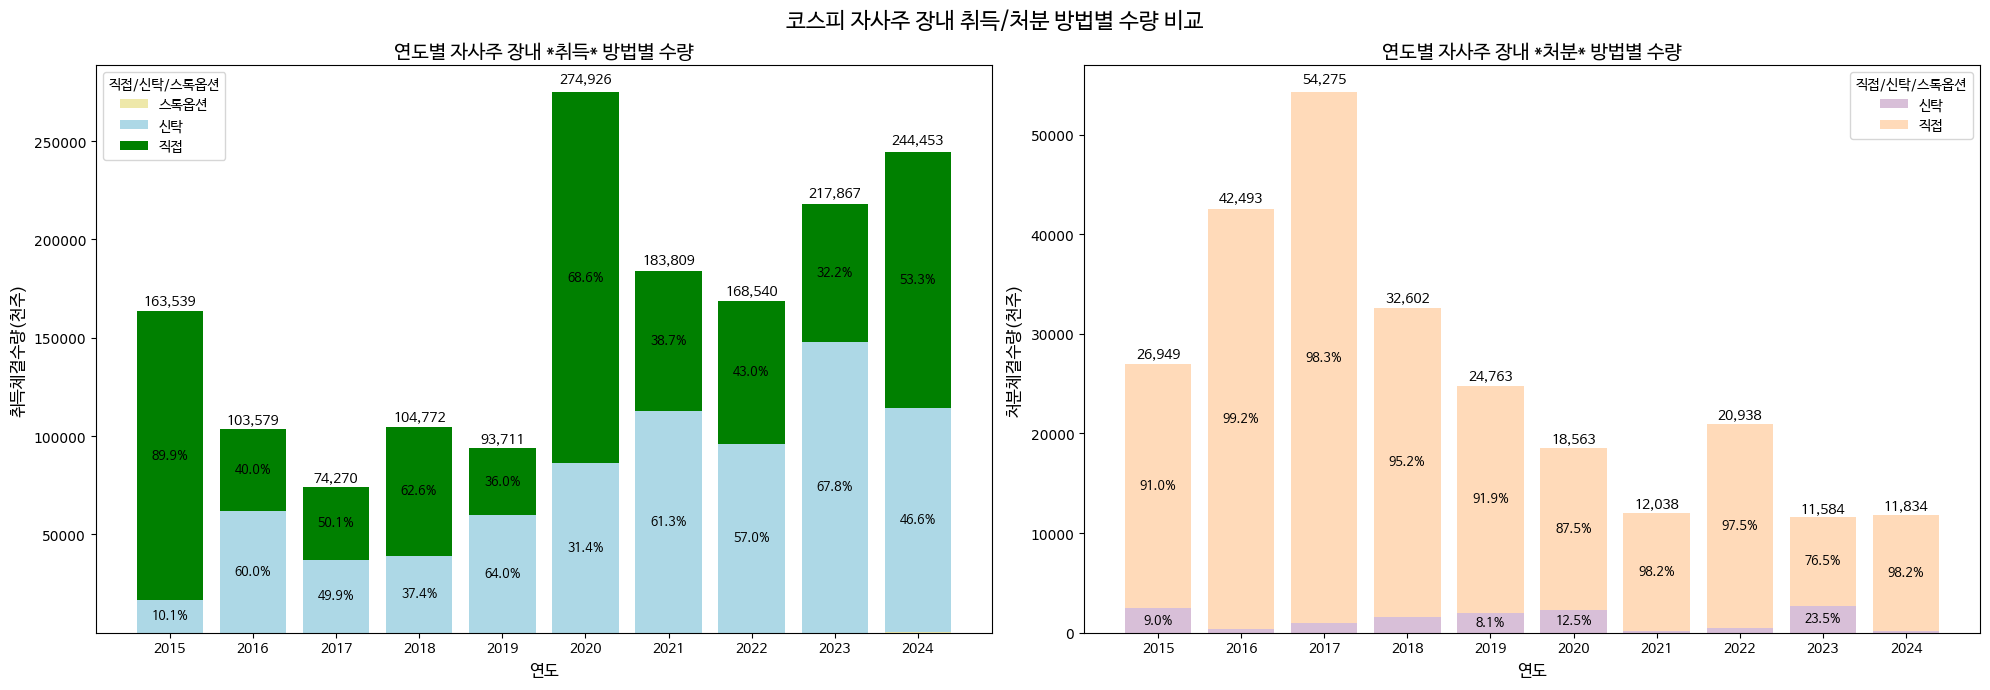

In [29]:
# 필터링할 조건 설정하기

# 유가 취득 케이스
con1 = grouped['시장구분'] == 'KOSPI'
# con2 = grouped['직접/신탁'] == '직접'
con3 = grouped['취득/처분'] == '취득'
grouped_con = grouped[con1 & con3]

# 유가 처분 케이스
con1 = grouped['시장구분'] == 'KOSPI'
#con2 = grouped['직접/신탁'] == '직접'
con3 = grouped['취득/처분'] == '처분'
grouped_con_dispose = grouped[con1 & con3]

# 필요한 포맷팅 함수 정의
def format_percentage(value):
    return f"{value:.1f}"

def format_number(value):
    return f"{int(value):,}"

# 하나의 figure에 두 개의 axes 생성 (좌우 배치)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 7))

# 1--------------------------------------------------
# 취득수량 비교 (왼쪽 그래프)
pivot_quantity = grouped_con.pivot_table(
    index='year',
    columns='직접/신탁',
    values='체결수량(천주)',
    aggfunc='sum'
).fillna(0)

colors_quantity = ['palegoldenrod', 'lightblue', 'green']
bottom_stack = np.zeros(len(pivot_quantity))
# NumPy 배열 대신 Pandas Series로 초기화
bottom_stack = pd.Series(0, index=pivot_quantity.index)

# 각 연도별 총합계 계산
year_totals_quantity = pivot_quantity.sum(axis=1)

for idx, col in enumerate(pivot_quantity.columns):
    bars = ax1.bar(
        pivot_quantity.index,
        pivot_quantity[col],
        bottom=bottom_stack,
        label=col,
        color=colors_quantity[idx]
    )

    # 각 영역의 중앙 위치 계산하여 비율 표시
    for i, (index, value) in enumerate(pivot_quantity[col].items()):
        # 퍼센트 계산
        percentage = (value / year_totals_quantity[index]) * 100 if year_totals_quantity[index] > 0 else 0

        # 값이 의미 있는 경우에만 레이블 표시 (5% 이상)
        if percentage > 5:
            center_y = bottom_stack.iloc[i] + value/2
            ax1.text(
                index, center_y,
                f"{format_percentage(percentage)}%",
                ha='center', va='center',
                fontproperties=font, fontsize=9,
                color='black'
            )

    bottom_stack += pivot_quantity[col]

# 막대 상단에 합계 표시
for i, (index, total) in enumerate(year_totals_quantity.items()):
    ax1.text(
        index, total + (total * 0.01),
        format_number(total),
        ha='center', va='bottom',
        fontproperties=font, fontsize=10,
        fontweight='bold'
    )

# 첫 번째 그래프 설정
ax1.set_xticks(pivot_quantity.index)
ax1.set_xticklabels(pivot_quantity.index, fontproperties=font, fontsize=10)
ax1.set_xlabel('연도', fontproperties=font, fontsize=12)
ax1.set_ylabel('취득체결수량(천주)', fontproperties=font, fontsize=12)
ax1.set_title('연도별 자사주 장내 *취득* 방법별 수량', fontproperties=font, fontsize=14)

# 2--------------------------------------------------
# 처분수량 비교 (오른쪽 그래프)
pivot_dispose = grouped_con_dispose.pivot_table(
    index='year',
    columns='직접/신탁',
    values='체결수량(천주)',
    aggfunc='sum'
).fillna(0)

colors_amount = ['thistle', 'peachpuff', 'brown']
# NumPy 배열 대신 Pandas Series로 초기화
bottom_stack = pd.Series(0, index=pivot_dispose.index)

# 각 연도별 총합계 계산
year_totals_amount = pivot_dispose.sum(axis=1)

for idx, col in enumerate(pivot_dispose.columns):
    bars = ax2.bar(
        pivot_dispose.index,
        pivot_dispose[col],
        bottom=bottom_stack,
        label=col,
        color=colors_amount[idx]
    )

    # 각 영역의 중앙 위치 계산하여 비율 표시
    for i, (index, value) in enumerate(pivot_dispose[col].items()):
        # 퍼센트 계산
        percentage = (value / year_totals_amount[index]) * 100 if year_totals_amount[index] > 0 else 0

        # 값이 의미 있는 경우에만 레이블 표시 (5% 이상)
        if percentage > 5:
            center_y = bottom_stack.iloc[i] + value/2
            ax2.text(
                index, center_y,
                f"{format_percentage(percentage)}%",
                ha='center', va='center',
                fontproperties=font, fontsize=9,
                color='black'
            )

    bottom_stack += pivot_dispose[col]

# 막대 상단에 합계 표시
for i, (index, total) in enumerate(year_totals_amount.items()):
    ax2.text(
        index, total + (total * 0.01),
        format_number(total),
        ha='center', va='bottom',
        fontproperties=font, fontsize=10,
        fontweight='bold'
    )

# 두 번째 그래프 설정
ax2.set_xticks(pivot_dispose.index)
ax2.set_xticklabels(pivot_dispose.index, fontproperties=font, fontsize=10)
ax2.set_xlabel('연도', fontproperties=font, fontsize=12)
ax2.set_ylabel('처분체결수량(천주)', fontproperties=font, fontsize=12)
ax2.set_title('연도별 자사주 장내 *처분* 방법별 수량', fontproperties=font, fontsize=14)

# 범례 설정 (두 그래프 모두에 적용)
for ax in [ax1, ax2]:
    legend = ax.legend(
        title='직접/신탁/스톡옵션',
        title_fontproperties=font,
        fontsize=10,
        prop=font
    )

# 전체 레이아웃 조정
plt.tight_layout()
plt.subplots_adjust(top=0.9)
fig.suptitle('코스피 자사주 장내 취득/처분 방법별 수량 비교', fontproperties=font, fontsize=16, y=0.98)
plt.show()

## 코스닥 법인 추이보기

### (취득) 연도별 유형별 취득수량 구하기

In [30]:
# 숫자 형식 변환 함수
def format_number(value):
    if isinstance(value, (int, float)):
        return f"{value:,.0f}"  # 천 단위 콤마 추가, 소수점 없이 정수 출력
    return value

def format_percentage(value):
    if isinstance(value, (int, float)):
        return f"{value:.2f}"  # 소수점 2자리까지 출력
    return value

# 필터링할 조건 설정하기
# 시장구분: 코스닥
# 취득

con1 = grouped['시장구분'] == 'KOSDAQ'
# con2 = grouped['직접/신탁'] == '직접'
con3 = grouped['취득/처분'] == '취득'
grouped_con = grouped[con1 &con3]

# 확인해보기
print('연도별 유형별 취득수량 확인해보기')

# 서식적용할 데이터프레임 복사
df_show = grouped_con.copy()

# 칼럼에 format_number 적용
df_show[['신청수량(천주)', '체결수량(천주)']] = df_show[['신청수량(천주)', '체결수량(천주)']].map(format_number)

# Pivot '직접/신탁'
pivoted_df = df_show.pivot_table(
    index='year',
    columns='직접/신탁',
    values=['신청수량(천주)','체결수량(천주)'],
    aggfunc='sum'
).reset_index().fillna(0)

# HTML 변환 및 커스텀 태그로 감싸기
html_table = pivoted_df.to_html(index=False, classes="dataframe", escape=False)

# 테이블을 <div> 태그로 감싸기
wrapped_html = f"""
<div class="table-container">
  {html_table}
</div>
"""
print(html_table)
pivoted_df

연도별 유형별 취득수량 확인해보기
<table border="1" class="dataframe dataframe">
  <thead>
    <tr>
      <th></th>
      <th>year</th>
      <th colspan="3" halign="left">신청수량(천주)</th>
      <th colspan="3" halign="left">체결수량(천주)</th>
    </tr>
    <tr>
      <th>직접/신탁</th>
      <th></th>
      <th>스톡옵션</th>
      <th>신탁</th>
      <th>직접</th>
      <th>스톡옵션</th>
      <th>신탁</th>
      <th>직접</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th></th>
      <td>2015</td>
      <td>0</td>
      <td>56,899</td>
      <td>42,341</td>
      <td>0</td>
      <td>22,780</td>
      <td>20,212</td>
    </tr>
    <tr>
      <th></th>
      <td>2016</td>
      <td>0</td>
      <td>78,633</td>
      <td>33,180</td>
      <td>0</td>
      <td>25,517</td>
      <td>18,169</td>
    </tr>
    <tr>
      <th></th>
      <td>2017</td>
      <td>0</td>
      <td>73,866</td>
      <td>21,778</td>
      <td>0</td>
      <td>31,473</td>
      <td>15,194</td>
    </tr>
    <tr>
      <th></th>
      <td>2018</td>
    

year 신청수량(천주)                   체결수량(천주)                 
직접/신탁           스톡옵션       신탁       직접     스톡옵션       신탁      직접
0      2015        0   56,899   42,341        0   22,780  20,212
1      2016        0   78,633   33,180        0   25,517  18,169
2      2017        0   73,866   21,778        0   31,473  15,194
3      2018        0   98,240   57,036        0   54,119  33,509
4      2019       35   70,149   34,103       35   37,982  19,643
5      2020       71  187,230   75,282       22   98,227  40,895
6      2021        0   71,446   34,549        0   32,830  24,106
7      2022        0  177,312   97,231        0   83,470  48,686
8      2023      192  146,691  114,513      113   92,298  45,266
9      2024        0  222,152  116,772        0  146,336  63,037

### (처분) 연도별 유형별 처분수량 구하기

In [31]:
# 숫자 형식 변환 함수
def format_number(value):
    if isinstance(value, (int, float)):
        return f"{value:,.0f}"  # 천 단위 콤마 추가, 소수점 없이 정수 출력
    return value

def format_percentage(value):
    if isinstance(value, (int, float)):
        return f"{value:.2f}"  # 소수점 2자리까지 출력
    return value

# 필터링할 조건 설정하기
# 시장구분: 코스닥
# 처분

con1 = grouped['시장구분'] == 'KOSDAQ'
# con2 = grouped['직접/신탁'] == '직접'
con3 = grouped['취득/처분'] == '처분'
grouped_con_dispose = grouped[con1 &con3]

# 숫자 형식 변환 함수
def format_number(value):
    if isinstance(value, (int, float)):
        return f"{value:,.0f}"  # 천 단위 콤마 추가, 소수점 없이 정수 출력
    return value

def format_percentage(value):
    if isinstance(value, (int, float)):
        return f"{value:.2f}"  # 소수점 2자리까지 출력
    return value

# 필터링할 조건 설정하기
# 시장구분: 유가
# 처분

con1 = grouped['시장구분'] == 'KOSPI'
# con2 = grouped['직접/신탁'] == '직접'
con3 = grouped['취득/처분'] == '처분'
grouped_con_dispose = grouped[con1 &con3]

# 확인해보기
print('연도별 유형별 처분수량 확인해보기')

# 서식적용할 데이터프레임 복사
df_show = grouped_con_dispose.copy()

# 칼럼에 format_number 적용
df_show[['신청수량(천주)', '체결수량(천주)']] = df_show[['신청수량(천주)', '체결수량(천주)']].map(format_number)

# Pivot '직접/신탁'
pivoted_df = df_show.pivot_table(
    index='year',
    columns='직접/신탁',
    values=['신청수량(천주)','체결수량(천주)'],
    aggfunc='sum'
).reset_index().fillna(0)

# HTML 변환 및 커스텀 태그로 감싸기
html_table = pivoted_df.to_html(index=False, classes="dataframe", escape=False)

# 테이블을 <div> 태그로 감싸기
wrapped_html = f"""
<div class="table-container">
  {html_table}
</div>
"""
print(html_table)
pivoted_df

연도별 유형별 처분수량 확인해보기
<table border="1" class="dataframe dataframe">
  <thead>
    <tr>
      <th></th>
      <th>year</th>
      <th colspan="2" halign="left">신청수량(천주)</th>
      <th colspan="2" halign="left">체결수량(천주)</th>
    </tr>
    <tr>
      <th>직접/신탁</th>
      <th></th>
      <th>신탁</th>
      <th>직접</th>
      <th>신탁</th>
      <th>직접</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th></th>
      <td>2015</td>
      <td>2,942</td>
      <td>25,475</td>
      <td>2,432</td>
      <td>24,518</td>
    </tr>
    <tr>
      <th></th>
      <td>2016</td>
      <td>513</td>
      <td>42,281</td>
      <td>324</td>
      <td>42,169</td>
    </tr>
    <tr>
      <th></th>
      <td>2017</td>
      <td>1,015</td>
      <td>55,307</td>
      <td>950</td>
      <td>53,325</td>
    </tr>
    <tr>
      <th></th>
      <td>2018</td>
      <td>1,593</td>
      <td>31,169</td>
      <td>1,575</td>
      <td>31,027</td>
    </tr>
    <tr>
      <th></th>
      <td>2019</td>
      <td>1,999</

year 신청수량(천주)         체결수량(천주)        
직접/신탁             신탁      직접       신탁      직접
0      2015    2,942  25,475    2,432  24,518
1      2016      513  42,281      324  42,169
2      2017    1,015  55,307      950  53,325
3      2018    1,593  31,169    1,575  31,027
4      2019    1,999  22,770    1,999  22,764
5      2020    2,431  16,268    2,316  16,248
6      2021      606  11,823      215  11,823
7      2022      661  20,433      517  20,422
8      2023    2,728   9,155    2,727   8,858
9      2024      216  12,619      216  11,619

### (취득/처분) 직접 vs 신탁 비중확인하기

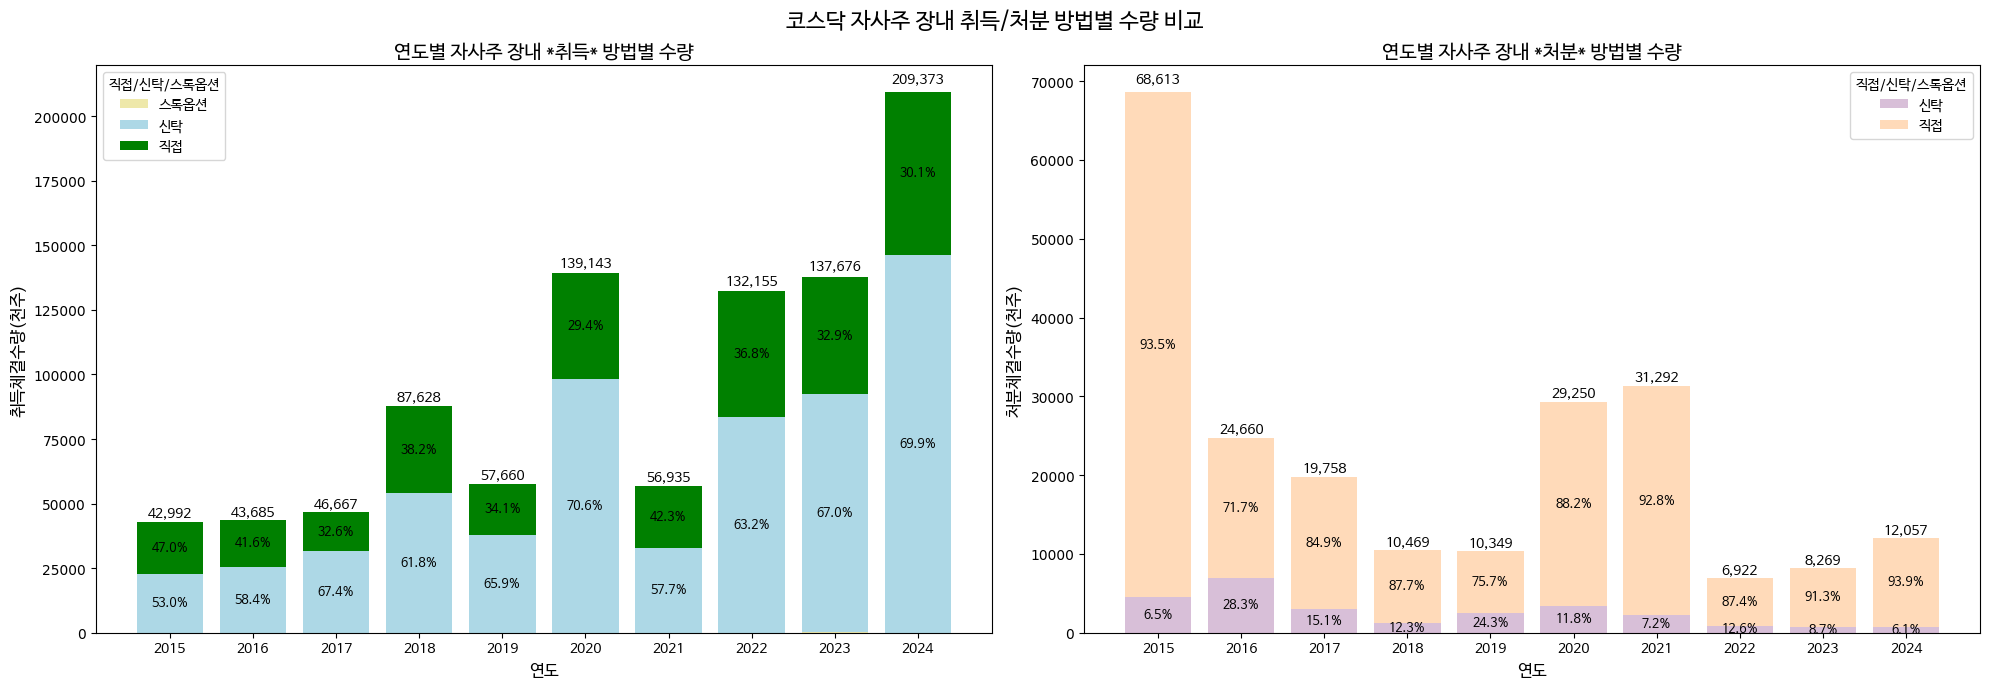

In [32]:
# 필터링할 조건 설정하기

# 코스닥 취득 케이스
con1 = grouped['시장구분'] == 'KOSDAQ'
# con2 = grouped['직접/신탁'] == '직접'
con3 = grouped['취득/처분'] == '취득'
grouped_con = grouped[con1 & con3]

# 코스닥 처분 케이스
con1 = grouped['시장구분'] == 'KOSDAQ'
#con2 = grouped['직접/신탁'] == '직접'
con3 = grouped['취득/처분'] == '처분'
grouped_con_dispose = grouped[con1 & con3]

# 필요한 포맷팅 함수 정의
def format_percentage(value):
    return f"{value:.1f}"

def format_number(value):
    return f"{int(value):,}"

# 하나의 figure에 두 개의 axes 생성 (좌우 배치)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 7))

# 1--------------------------------------------------
# 취득수량 비교 (왼쪽 그래프)
pivot_quantity = grouped_con.pivot_table(
    index='year',
    columns='직접/신탁',
    values='체결수량(천주)',
    aggfunc='sum'
).fillna(0)

colors_quantity = ['palegoldenrod', 'lightblue', 'green']
bottom_stack = np.zeros(len(pivot_quantity))
# NumPy 배열 대신 Pandas Series로 초기화
bottom_stack = pd.Series(0, index=pivot_quantity.index)

# 각 연도별 총합계 계산
year_totals_quantity = pivot_quantity.sum(axis=1)

for idx, col in enumerate(pivot_quantity.columns):
    bars = ax1.bar(
        pivot_quantity.index,
        pivot_quantity[col],
        bottom=bottom_stack,
        label=col,
        color=colors_quantity[idx]
    )

    # 각 영역의 중앙 위치 계산하여 비율 표시
    for i, (index, value) in enumerate(pivot_quantity[col].items()):
        # 퍼센트 계산
        percentage = (value / year_totals_quantity[index]) * 100 if year_totals_quantity[index] > 0 else 0

        # 값이 의미 있는 경우에만 레이블 표시 (5% 이상)
        if percentage > 5:
            center_y = bottom_stack.iloc[i] + value/2
            ax1.text(
                index, center_y,
                f"{format_percentage(percentage)}%",
                ha='center', va='center',
                fontproperties=font, fontsize=9,
                color='black'
            )

    bottom_stack += pivot_quantity[col]

# 막대 상단에 합계 표시
for i, (index, total) in enumerate(year_totals_quantity.items()):
    ax1.text(
        index, total + (total * 0.01),
        format_number(total),
        ha='center', va='bottom',
        fontproperties=font, fontsize=10,
        fontweight='bold'
    )

# 첫 번째 그래프 설정
ax1.set_xticks(pivot_quantity.index)
ax1.set_xticklabels(pivot_quantity.index, fontproperties=font, fontsize=10)
ax1.set_xlabel('연도', fontproperties=font, fontsize=12)
ax1.set_ylabel('취득체결수량(천주)', fontproperties=font, fontsize=12)
ax1.set_title('연도별 자사주 장내 *취득* 방법별 수량', fontproperties=font, fontsize=14)

# 2--------------------------------------------------
# 처분수량 비교 (오른쪽 그래프)
pivot_dispose = grouped_con_dispose.pivot_table(
    index='year',
    columns='직접/신탁',
    values='체결수량(천주)',
    aggfunc='sum'
).fillna(0)

colors_amount = ['thistle', 'peachpuff', 'brown']
# NumPy 배열 대신 Pandas Series로 초기화
bottom_stack = pd.Series(0, index=pivot_dispose.index)

# 각 연도별 총합계 계산
year_totals_amount = pivot_dispose.sum(axis=1)

for idx, col in enumerate(pivot_dispose.columns):
    bars = ax2.bar(
        pivot_dispose.index,
        pivot_dispose[col],
        bottom=bottom_stack,
        label=col,
        color=colors_amount[idx]
    )

    # 각 영역의 중앙 위치 계산하여 비율 표시
    for i, (index, value) in enumerate(pivot_dispose[col].items()):
        # 퍼센트 계산
        percentage = (value / year_totals_amount[index]) * 100 if year_totals_amount[index] > 0 else 0

        # 값이 의미 있는 경우에만 레이블 표시 (5% 이상)
        if percentage > 5:
            center_y = bottom_stack.iloc[i] + value/2
            ax2.text(
                index, center_y,
                f"{format_percentage(percentage)}%",
                ha='center', va='center',
                fontproperties=font, fontsize=9,
                color='black'
            )

    bottom_stack += pivot_dispose[col]

# 막대 상단에 합계 표시
for i, (index, total) in enumerate(year_totals_amount.items()):
    ax2.text(
        index, total + (total * 0.01),
        format_number(total),
        ha='center', va='bottom',
        fontproperties=font, fontsize=10,
        fontweight='bold'
    )

# 두 번째 그래프 설정
ax2.set_xticks(pivot_dispose.index)
ax2.set_xticklabels(pivot_dispose.index, fontproperties=font, fontsize=10)
ax2.set_xlabel('연도', fontproperties=font, fontsize=12)
ax2.set_ylabel('처분체결수량(천주)', fontproperties=font, fontsize=12)
ax2.set_title('연도별 자사주 장내 *처분* 방법별 수량', fontproperties=font, fontsize=14)

# 범례 설정 (두 그래프 모두에 적용)
for ax in [ax1, ax2]:
    legend = ax.legend(
        title='직접/신탁/스톡옵션',
        title_fontproperties=font,
        fontsize=10,
        prop=font
    )

# 전체 레이아웃 조정
plt.tight_layout()
plt.subplots_adjust(top=0.9)
fig.suptitle('코스닥 자사주 장내 취득/처분 방법별 수량 비교', fontproperties=font, fontsize=16, y=0.98)
plt.show()